In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Подход 1: градиентный бустинг "в лоб"

In [2]:
features = pd.read_csv('C:/Users/Ilya/Downloads/features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16,2449,0,4,1974,3,63


1\. Пропуски в first\_blood_... объясняются прямо в описании данных "Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение". 

Пропуски в полях  ...\_flying\_courier\_time объясняются тем, что предметы не были активированы в первые 5 минут. Flying Courier — это предмет, который создаёт маленького, быстрого, летающего осла, который может носить предметы вам и вашим союзникам с базы и из секретного магазина

In [3]:
features.isnull().sum().sort_values(ascending = False)[:5]

first_blood_player2            43987
radiant_flying_courier_time    27479
dire_flying_courier_time       26098
first_blood_player1            19553
first_blood_team               19553
dtype: int64

2\. Столбец, содержащий целевую переменную - radiant_win

In [4]:
#preprocessing
#features.start_time = pd.to_datetime(features.start_time,unit='s')
features = features.fillna(features.median())

In [5]:
targets = ['duration', 'radiant_win', 'tower_status_radiant', 
           'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']

from sklearn import cross_validation
X_train, X_test, y_train, y_test = \
    cross_validation.train_test_split(features.drop(targets, axis = 1), features.radiant_win, test_size=0.5, random_state=1)
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48615, 102), (48615, 102), (48615L,), (48615L,))

3\. Проводим перебор параметров с кроссвалидацией

In [6]:
import datetime
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

start_time = datetime.datetime.now()

five = KFold(len(X_train), n_folds=5, shuffle=True, random_state=1)

parameters = {'n_estimators':[5,10,20,30], 
              'learning_rate':[1, 0.5, 0.3, 0.2, 0.1]}
gb = GradientBoostingClassifier(random_state=1)

grid = GridSearchCV(gb, parameters, scoring='roc_auc',
    cv=five, verbose = 10, n_jobs=4)

grid.fit(X_train, y_train)

print 'Time elapsed:', datetime.datetime.now() - start_time

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 10.7min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time elapsed: 0:11:09.056000


3\. Кросс-валидация для градиентного бустинга с 30 деревьями заняла примерно 2,5 минуты из 12 за счет обучения на половине выборки и распараллеливания подбора learning rate на 4 процессора. Качество на графике ниже:

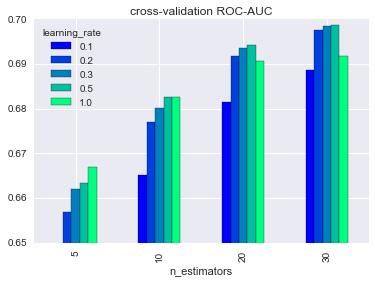

In [7]:
import matplotlib.cm as cm
grid_scores = pd.DataFrame([[x.parameters['n_estimators'], x.parameters['learning_rate'], x.mean_validation_score] 
                            for x in grid.grid_scores_], columns = ['n_estimators', 'learning_rate', 'score'])
plot = pd.crosstab(grid_scores.n_estimators, 
                   grid_scores.learning_rate, grid_scores.score, aggfunc='mean').plot(kind = 'bar', colormap=cm.winter)

plot.set_ylim([0.65,0.7])
plot.set_title('cross-validation ROC-AUC')

In [8]:
gb_best = grid.best_estimator_
gb_best

GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

4\. Видно, что при 30 деревьях качество продолжает расти - следовательно, надо увеличивать количество деревьев. Для ускорения можно распараллелить подбор параметров для градиентного бустинга

## Подход 2: логистическая регрессия

Проводим стандартизацию

In [10]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = pd.DataFrame(std.fit_transform(X_train), columns = X_train.columns, index = X_train.index)

Находим параметры

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

start_time = datetime.datetime.now()

five = KFold(len(X_train_std), n_folds=5, shuffle=True, random_state=1)

parameters = {'C':[1,0.5, 0.2, 0.1, 0.05, 0.01, 0.001]}

lg = LogisticRegression(random_state = 1)

grid = GridSearchCV(lg, parameters, scoring='roc_auc',
    cv=five, verbose = 10, n_jobs=4)

grid.fit(X_train_std, y_train)

print 'Time elapsed:', datetime.datetime.now() - start_time

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   39.6s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   47.1s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Time elapsed: 0:00:51.712000


       C     score
0  1.000  0.717792
1  0.500  0.717794
2  0.200  0.717798
3  0.100  0.717805
4  0.050  0.717818
5  0.010  0.717873
6  0.001  0.717388


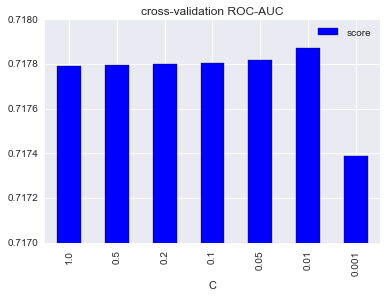

In [12]:
import matplotlib.cm as cm
grid_scores = pd.DataFrame([[x.parameters['C'], x.mean_validation_score] 
                            for x in grid.grid_scores_], columns = ['C', 'score'])
plot = grid_scores.plot(x = 'C', y = 'score', kind = 'bar', colormap=cm.winter)

plot.set_ylim([0.717,0.718])
plot.set_title('cross-validation ROC-AUC')
print grid_scores

Качество получается чуть выше случайного леса

Теперь выкидываем категориальные переменные с номерами героев

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

start_time = datetime.datetime.now()

heroes = ['r%d_hero' % (p+1) for p in range(5)] + [ 'd%d_hero' % (p+1) for p in range(5)]

five = KFold(len(X_train_std), n_folds=5, shuffle=True, random_state=1)

parameters = {'C':[1,0.5, 0.2, 0.1, 0.05, 0.01, 0.001]}

lg = LogisticRegression(random_state = 1)

grid = GridSearchCV(lg, parameters, scoring='roc_auc',
    cv=five, verbose = 10, n_jobs=4)

grid.fit(X_train_std.drop(heroes, axis = 1), y_train)

print 'Time elapsed:', datetime.datetime.now() - start_time

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   38.6s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Time elapsed: 0:00:40.855000


       C     score
0  1.000  0.717732
1  0.500  0.717734
2  0.200  0.717739
3  0.100  0.717746
4  0.050  0.717757
5  0.010  0.717818
6  0.001  0.717318


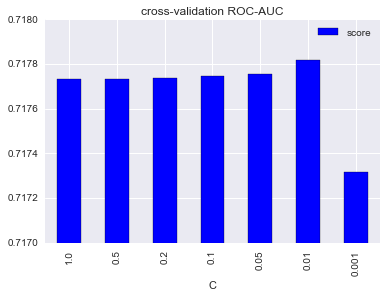

In [14]:
import matplotlib.cm as cm
grid_scores = pd.DataFrame([[x.parameters['C'], x.mean_validation_score] 
                            for x in grid.grid_scores_], columns = ['C', 'score'])
plot = grid_scores.plot(x = 'C', y = 'score', kind = 'bar', colormap=cm.winter)

plot.set_ylim([0.717,0.718])
plot.set_title('cross-validation ROC-AUC')
print grid_scores

качество не упало - следовательно, в таком виде переменные героев бесполезны

Собираем героев в ```hero_set```

In [15]:
hero_set = set()
for i in range(1,6):
    hero_set = hero_set | set(features['r'+str(i)+'_hero']) | set(features['d'+str(i)+'_hero'])
    
len(hero_set), max(hero_set)

(108, 112)

Собираем по переменной на каждого героя

In [16]:
# N — количество различных героев в выборке
X_pick = np.zeros((features.shape[0],112))

for i, match_id in enumerate(features.index):
    for p in xrange(5):
        X_pick[i, features.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [17]:
X_pick.mean(axis = 0)

array([ -2.29353080e-03,   9.15355343e-04,   1.00791937e-03,
         1.02848915e-05,   1.24447187e-03,   1.54273372e-04,
         5.64640543e-03,   8.02221537e-04,   1.11076828e-03,
        -4.83389900e-04,   3.47835030e-02,  -4.83389900e-04,
         1.54273372e-04,   2.11868765e-03,  -2.24210635e-03,
        -8.84500669e-04,   2.15982721e-04,  -6.17093490e-04,
         7.40512188e-04,  -1.58387329e-03,  -4.21680551e-03,
        -6.58233056e-04,   7.71366862e-04,   0.00000000e+00,
        -3.71284583e-03,  -2.14954232e-03,   5.86238815e-04,
        -2.19068189e-03,   3.49686311e-04,   1.51187905e-03,
        -2.90033940e-03,   2.98261853e-04,   1.13133806e-04,
         1.16219274e-03,   7.91936645e-04,   1.45016970e-03,
         6.17093490e-05,   2.26267613e-04,  -7.98107580e-03,
         6.17093490e-05,  -1.02848915e-04,   1.26504165e-03,
         3.80540985e-04,   2.05697830e-04,  -4.83389900e-04,
        -3.15746169e-03,  -5.13216086e-03,  -7.30227296e-04,
         5.45099249e-04,

Есть несколько героев, которых ни разу не выбрали - оставим их для простоты кода

Присоединяем новые переменные к уже готовым

In [18]:
X_pick = pd.DataFrame(X_pick, index = features.index, 
                      columns = ['hero_%d' % (p+1) for p in range(112)])

In [19]:
X_train_with_heroes = pd.concat([X_train_std, X_pick], axis = 1).dropna(axis=0).loc[y_train.index,:]
X_train_with_heroes.shape, X_train_std.shape

((48615, 214), (48615, 102))

In [20]:
X_train_with_heroes.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
match_id,,,,,,,,,,,,,,,,,,,,,
93221,0.899074,-0.576047,-1.240711,0.504580,0.517064,1.384979,1.419252,0.960583,-0.580809,1.484228,...,0,0,0,0,0,0,0,0,0,-1
63428,0.504542,-0.576047,0.265038,-0.394092,-0.894380,-1.305261,-1.128007,-0.538237,-0.580809,-0.115509,...,0,0,0,1,0,0,0,0,0,0
79280,0.773745,1.538646,1.862976,-1.292764,-1.182322,-0.994350,-0.906506,-0.538237,1.006288,-0.115509,...,0,0,0,0,0,0,0,0,0,1
8743,-1.899034,-0.576047,-0.687579,0.504580,0.490567,-0.776281,-0.463505,-0.538237,-0.580809,-0.115509,...,0,0,0,0,0,0,0,-1,0,0
60159,0.460992,-0.576047,0.633793,0.504580,0.333347,0.471679,1.087001,-0.538237,-0.580809,0.684359,...,0,0,0,0,0,0,0,0,0,0


Обучаемся с переменными по героям

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  1.3min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Time elapsed: 0:01:22.235000
       C     score
0  1.000  0.751068
1  0.500  0.751076
2  0.200  0.751094
3  0.100  0.751115
4  0.050  0.751135
5  0.010  0.750627
6  0.001  0.741848


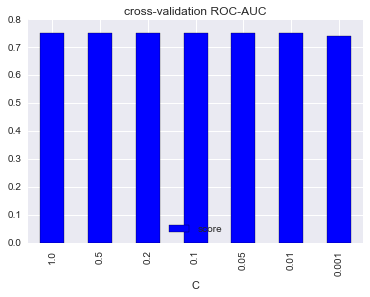

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

start_time = datetime.datetime.now()

heroes = ['r%d_hero' % (p+1) for p in range(5)] + [ 'd%d_hero' % (p+1) for p in range(5)]

five = KFold(len(X_train_with_heroes), n_folds=5, shuffle=True, random_state=1)

parameters = {'C':[1,0.5, 0.2, 0.1, 0.05, 0.01, 0.001]}

lg = LogisticRegression(random_state = 1)

grid = GridSearchCV(lg, parameters, scoring='roc_auc',
    cv=five, verbose = 10, n_jobs=4)

grid.fit(X_train_with_heroes, y_train)

print 'Time elapsed:', datetime.datetime.now() - start_time

import matplotlib.cm as cm
grid_scores = pd.DataFrame([[x.parameters['C'], x.mean_validation_score] 
                            for x in grid.grid_scores_], columns = ['C', 'score'])
plot = grid_scores.plot(x = 'C', y = 'score', kind = 'bar', colormap=cm.winter)

#plot.set_ylim([0.717,0.718])
plot.set_title('cross-validation ROC-AUC')
print grid_scores

Видим сильный прирост качества, +4 п.п. !

# Проверка финальной модели

In [24]:
data_eval = pd.read_csv('C:/Users/Ilya/Downloads/features_test.csv', index_col='match_id')
data_eval = data_eval.fillna(data_eval.median())
X_eval_std = pd.DataFrame(std.fit_transform(data_eval), columns = data_eval.columns, index = data_eval.index)

X_pick_eval = np.zeros((data_eval.shape[0],112))

for i, match_id in enumerate(data_eval.index):
    for p in xrange(5):
        X_pick_eval[i, data_eval.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_eval[i, data_eval.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_pick_eval = pd.DataFrame(X_pick_eval, index = data_eval.index, 
                      columns = ['hero_%d' % (p+1) for p in range(112)])

X_eval_with_heroes = pd.concat([X_eval_std, X_pick_eval], axis = 1).dropna(axis=0).loc[X_eval_std.index,:]

pd.Series(grid.best_estimator_.predict_proba(X_eval_with_heroes)[:,1], 
          index = X_eval_with_heroes.index).to_csv('C:/Users/Ilya/Downloads/Dota prediction.csv', header = ['radiant_win'])

Дает качество 0.75443